# Get rich or die… coding.

People want to become rich, to secure their old age, live comfort life and travel a lot. Or to make fortune and save the world. Whatever the reason is to become rich, a person has to do what knows how to do it best. I this post, I will describe my thoughts on how to create a simple machine learning model on stock price prediction in Python.

DISCLAIMER / LEGAL NOTICE
The data in this article is for your information only. It does not constitute investment advice.

### Post outline
- Defining the scope of our task
- What stock to choose?
- What to include in model as features?
- What to consider before creating predicting model in Python?
- Summary


### Defining the scope of our task

The task is to predict a next trading day price of a certain stock. Since price of a stock is continuous variable, regression analysis will be applied. The stock price data will be retrieved from **pandas_datareader** package.


In [137]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd

### Which stock to choose?
When I asked this question myself, I did not think a lot to answer. A stock has to be liquid that is first requirement.

Definition from Investopedia:

*A stock's liquidity generally refers to how rapidly shares of a stock can be bought or sold without substantially impacting the stock price. Stocks with low liquidity may be difficult to sell and may cause you to take a bigger loss if you cannot sell the shares when you want to.*

By other words, a liquid stock easy to buy, easy to sell and supposedly easy to predict.

*Liquidity can be calculated as ratio of volume traded multiplied by the closing price divided by the price range from high to low, for the whole trading day, on a logarithmic scale (from https://www.cfainstitute.org).*

To roughly estimate liquidity, one just needs to multiply stock volume by stock closed price at the last trading day, the higher number, the more liquid stock is. Note: it is supposed there were no abnormal volume increase last trading day. One can ask: There are many liquid stocks at the exchange, which should I choose? The way I did, just picked the most liquid in its sector (Pfizer, ticker PFE, sector - Healthcare).


### What to include in model as features?
The more relevant information the better. I decided to include gold price and S&P500 index, in some cases they could act as leading indicators… I hope. Also adding day of the week would be beneficial, since there happens large price change from Friday to Monday.

In [138]:
pfe = data.DataReader('PFE', start='2018', end='2022',
                       data_source='yahoo')

In [139]:
sp500 = data.DataReader('^GSPC', start='2018', end='2022',
                       data_source='yahoo')

In [140]:
gold = data.DataReader('GOLD', start='2018', end='2022',
                       data_source='yahoo')

In [141]:
gold.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,15.24,14.61,14.65,15.20,15223200.0,14.588737
2018-01-03,15.27,14.74,15.24,15.00,15155900.0,14.396777
2018-01-04,15.05,14.79,15.03,15.03,8936100.0,14.425571
2018-01-05,15.00,14.87,14.99,14.95,6515600.0,14.348790
2018-01-08,14.95,14.64,14.88,14.74,8362600.0,14.147237


### What to consider before creating predicting model in Python?
The price is time series which is not stationary. As I was taught, predictive model has to be based on stationary time series. The stationarity definition by Wikipedia:

*In mathematics and statistics, a stationary process (or a strict/strictly stationary process or strong/strongly stationary process) is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.*

Thus, we have to convert the time series to stationary. Non-stationary time series consists of the following components: level, trend, seasonality, noise. To simplify the task we will decompose trend only from a stock price and use Augmented Dickey-Fuller test to verify stationarity.


In [142]:
plt.style.use('fivethirtyeight')

Let's have a look at the graph

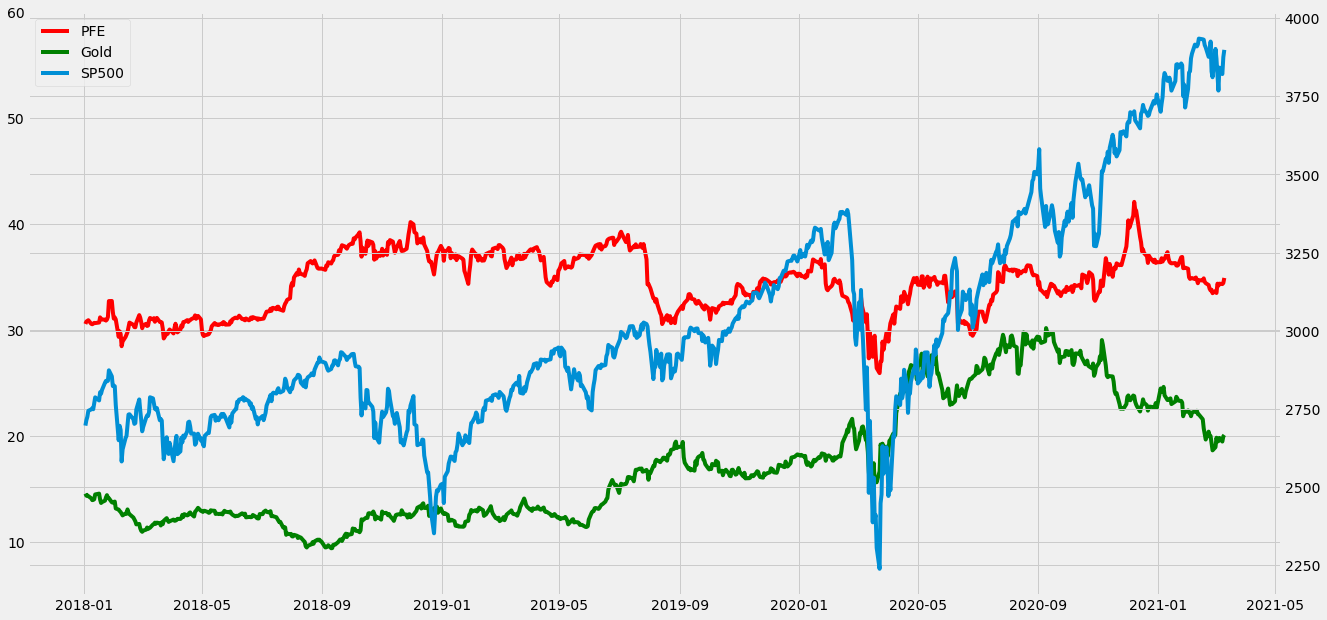

In [150]:
#plt.rcParams['figure.figsize'] = (20, 10)
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_ylim([5, 60])
ax1.plot(pfe['Adj Close'], color='Red', label = 'PFE')
ax1.plot(gold['Adj Close'], color='Green', label='Gold')
ax2 = ax1.twinx()
ax2.plot(sp500['Adj Close'], label = 'SP500')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [99]:
from statsmodels.tsa.stattools import adfuller

Defining Augmented Dickey-Fuller test function

In [100]:
def ADF_Stationarity_Test(timeseries, significance_level):
    result = adfuller(timeseries, regression='ctt')
    print(f'p-value: {result[1]} and significance level: {significance_level}')
    if result[1] < significance_level:
        print ('Timeseries is stationary')
    else:
        print ('Timeseries is NOT stationary')

In [101]:
ADF_Stationarity_Test (pfe['Adj Close'], 0.05)

p-value: 0.414170479420067 and significance level: 0.05
Timeseries is NOT stationary


As we can see from the line above the price is NOT stationary timeseries.

The function below adds moving averages to the dataframe with different time frames.

In [102]:
def adding_MAs(df, col_label, MAs=[5, 10, 15, 20, 30]):
    for period in MAs:
        df['MA'+ str(period)]=df[col_label].rolling(period).mean()
    df[col_label + '-MA30'] = df[col_label] - df['MA30'] #This will become our target
    df.dropna(inplace=True)
    return df
    

In [103]:
def renaming_cols(df, prefix):
    cols = df.columns.tolist()
    cols_new = {}
    for item in cols:
        cols_new[item]=prefix+item
    df.rename(columns =cols_new, inplace=True)
    

In [104]:
pfe = adding_MAs(pfe, 'Adj Close')

In [105]:
gold = adding_MAs(gold, 'Adj Close')

In [106]:
sp500 = adding_MAs(sp500, 'Adj Close')

In [107]:
pfe['Volume by Adj Close']=pfe['Volume'] * pfe['Adj Close']

In [108]:
pfe.drop(columns=['High', 'Low', 'Open', 'Volume', 'Close', 'Adj Close'], inplace=True)

In [109]:
gold.drop(columns=['High', 'Low', 'Open', 'Volume', 'Close', 'Adj Close'], inplace=True)

In [110]:
sp500.drop(columns=['High', 'Low', 'Open', 'Volume', 'Close', 'Adj Close'], inplace=True)

In [111]:
renaming_cols(pfe, 'pfe_')

In [112]:
renaming_cols(gold, 'gold_')

In [113]:
renaming_cols(sp500, 'sp500_')

In [114]:
ADF_Stationarity_Test (pfe['pfe_Adj Close-MA30'], 0.05)

p-value: 1.7556373299318893e-06 and significance level: 0.05
Timeseries is stationary


From the line above we see that 'pfe_Adj Close-MA30' field is stationary timeseries and it will become our target. To define the price one just needs to add last MA30 to the predicted value.

Stationary target variable shown on the graph below. By try and error I identified that "Adj Close-MA30" gives best r2 score.

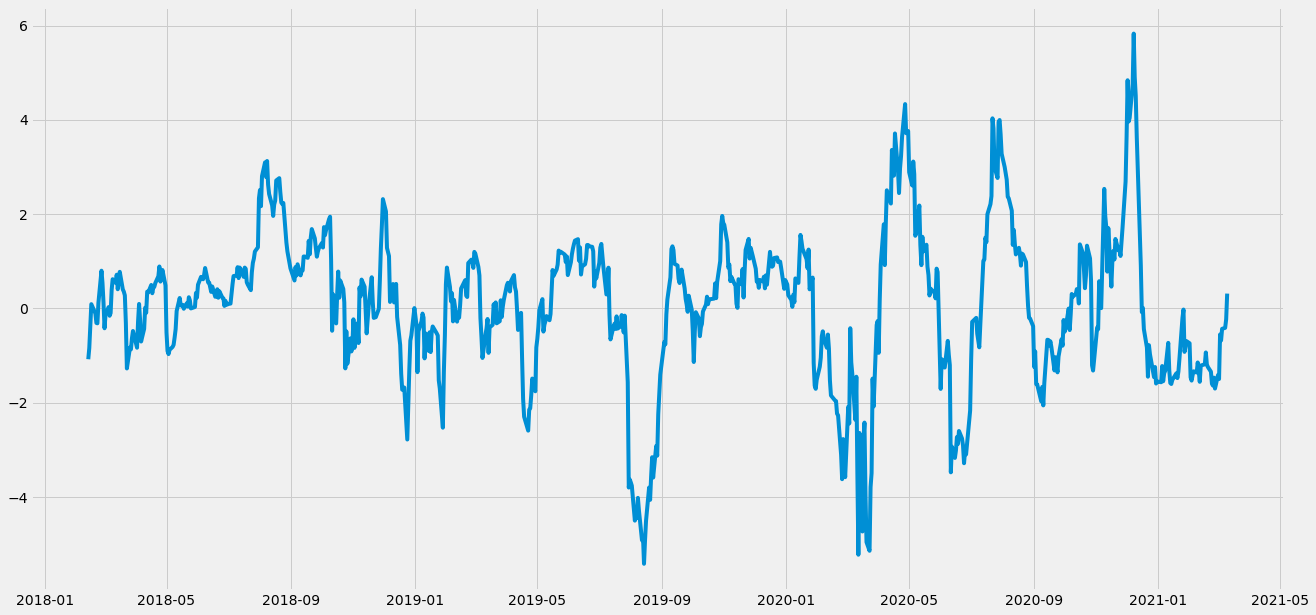

In [115]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(pfe['pfe_Adj Close-MA30'])
plt.show()

Now time to merge all three dataframes into one

In [116]:
final_df = pfe.merge(gold, on=['Date'])

In [117]:
final_df = final_df.merge(sp500, on=['Date'])

Since we predicting stock price on next trading day we have to shift our target variable by one row.

In [118]:
final_df ['pfe_Adj Close-MA30'] = final_df ['pfe_Adj Close-MA30'].shift(-1)

In [119]:
final_df.tail()

,pfe_MA5,pfe_MA10,pfe_MA15,pfe_MA20,pfe_MA30,pfe_Adj Close-MA30,pfe_Volume by Adj Close,gold_MA5,gold_MA10,gold_MA15,gold_MA20,gold_MA30,gold_Adj Close-MA30,sp500_MA5,sp500_MA10,sp500_MA15,sp500_MA20,sp500_MA30,sp500_Adj Close-MA30
Date,,,,,,,,,,,,,,,,,,,
2021-03-04,33.856000,33.946,34.183333,34.3545,34.878712,-0.432132,1.552769e+09,19.308,19.609719,20.186080,20.699712,21.358337,-1.818336,3834.289990,3859.080005,3881.326676,3885.758508,3859.914014,-91.444043
2021-03-05,34.035999,33.941,34.180666,34.3295,34.822132,-0.411911,1.051251e+09,19.542,19.624871,20.036258,20.597300,21.233990,-1.393989,3840.447998,3852.603003,3876.364014,3884.268506,3859.543009,-17.603068
2021-03-08,34.167999,33.950,34.156000,34.3010,34.761910,-0.230949,8.357526e+08,19.648,19.531371,19.866424,20.460966,21.105276,-1.605276,3824.354004,3847.088013,3868.798682,3880.994507,3858.872347,-37.522249
2021-03-09,34.356000,34.004,34.140000,34.2825,34.680950,0.315000,8.662590e+08,19.674,19.523699,19.759118,20.342662,20.993892,-1.003892,3825.383984,3846.494995,3864.988672,3878.987000,3859.541675,15.898267
2021-03-10,34.464000,34.122,34.142666,34.2805,34.615000,NaN,1.169886e+09,19.798,19.535000,19.718211,20.232352,20.892149,-0.772148,3841.202002,3843.833008,3862.820671,3878.366003,3861.181340,37.628719


In [120]:
final_df.reset_index(inplace=True)

In [121]:
final_df['Weekday'] = final_df['Date'].dt.day_name()

In [122]:
final_df =pd.get_dummies(final_df, columns=['Weekday'])

In [123]:
final_df.drop(columns=['Date'], inplace=True)

In [124]:
final_df.dropna( inplace=True)

The final dataframe looks like this.

In [125]:
final_df

,pfe_MA5,pfe_MA10,pfe_MA15,pfe_MA20,pfe_MA30,pfe_Adj Close-MA30,pfe_Volume by Adj Close,gold_MA5,gold_MA10,gold_MA15,...,sp500_MA10,sp500_MA15,sp500_MA20,sp500_MA30,sp500_Adj Close-MA30,Weekday_Friday,Weekday_Monday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,29.207316,29.861376,30.540064,30.664088,30.679264,-0.839479,6.382091e+08,12.699879,13.035803,13.378127,...,2695.314966,2745.251318,2763.087988,2757.173991,-94.234049,0,0,0,1,0
1,29.242900,29.733444,30.460932,30.594246,30.653409,-0.380200,7.302847e+08,12.749788,12.965739,13.288547,...,2682.796948,2735.990641,2757.891479,2757.267985,-58.638102,0,0,0,0,1
2,29.595346,29.638554,30.394381,30.554408,30.634685,0.091209,6.833998e+08,12.770902,12.862082,13.195128,...,2673.718945,2728.787305,2754.549976,2757.872648,-26.672697,0,0,1,0,0
3,29.951181,29.608902,30.259281,30.539965,30.629254,-0.106145,8.497156e+08,12.793937,12.808334,13.094670,...,2670.727954,2719.410628,2750.645972,2758.146981,-25.927010,1,0,0,0,0
4,30.179933,29.722430,30.109501,30.515353,30.614804,-0.307917,8.299078e+08,12.715235,12.733471,12.998691,...,2677.459961,2710.259294,2744.810474,2757.250651,-40.990641,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,33.780000,33.982000,34.219333,34.386500,34.942286,-0.678712,1.580093e+09,19.272000,19.678316,20.377136,...,3873.630005,3890.754004,3888.843506,3862.693351,-42.973381,0,0,0,0,1
768,33.856000,33.946000,34.183333,34.354500,34.878712,-0.432132,1.552769e+09,19.308000,19.609719,20.186080,...,3859.080005,3881.326676,3885.758508,3859.914014,-91.444043,0,0,1,0,0
769,34.035999,33.941000,34.180666,34.329500,34.822132,-0.411911,1.051251e+09,19.542000,19.624871,20.036258,...,3852.603003,3876.364014,3884.268506,3859.543009,-17.603068,1,0,0,0,0
770,34.167999,33.950000,34.156000,34.301000,34.761910,-0.230949,8.357526e+08,19.648000,19.531371,19.866424,...,3847.088013,3868.798682,3880.994507,3858.872347,-37.522249,0,1,0,0,0


In [126]:
X = final_df.drop(columns='pfe_Adj Close-MA30')
y = final_df['pfe_Adj Close-MA30']

Scaling data.

In [127]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
X=scaling.fit_transform(X)

In [128]:
from sklearn.model_selection import train_test_split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
regr= SVR()
params ={'kernel':['linear', 'rbf'],
         'C':[0.2, 0.5, 1, 10, 100],
         'epsilon':[1, 0.1, 0.01, 0.001, 0.0001]
        }
gridSr = GridSearchCV(regr, params, n_jobs=5, verbose=4, scoring='r2')

In [131]:
gridSr.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:   23.3s finished


GridSearchCV(estimator=SVR(), n_jobs=5,
             param_grid={'C': [0.2, 0.5, 1, 10, 100],
                         'epsilon': [0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring='r2', verbose=4)

In [132]:
y_predict = gridSr.predict(X_test)

In [133]:
from sklearn.metrics import r2_score

In [134]:
r2_score (y_test, y_predict)

0.8085984852899742

In [135]:
gridSr.best_score_

0.8375908855817281

In [136]:
gridSr.best_params_

{'C': 100, 'epsilon': 0.1, 'kernel': 'linear'}

### Summary
With this simple model we managed to achieve 0.8 r2-score result which is not bad. Further steps would be to deploy the model and create web API to work with it. Also one can try to play with this model and try different parameters like shifting target variable by 5 and try to predict stock price in 5 days. Or one can try neural network instead of SVR.
Please refer to my GitHub profile for the complete code for this article.
https://github.com/Ruslion